# Plot temperature response over time

## Imports:

In [2]:
import xarray as xr
from IPython.display import clear_output
import numpy as np
import os
import re
from pathlib import Path
import pandas as pd
import tqdm
from scmdata import df_append, ScmDataFrame
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
from ar6_ch6_rcmipfigs.constants import BASE_DIR
from ar6_ch6_rcmipfigs.constants import OUTPUT_DATA_DIR, INPUT_DATA_DIR, RESULTS_DIR

#PATH_DATASET = OUTPUT_DATA_DIR + '/forcing_data_rcmip_models.nc'
PATH_DT = OUTPUT_DATA_DIR + '/dT_data_rcmip_models.nc'

TypeError: expected str, bytes or os.PathLike object, not NoneType

In [4]:
FIGURE_DIR = RESULTS_DIR + '/figures/'

In [5]:

climatemodel = 'climatemodel'
scenario = 'scenario'
variable = 'variable'
time = 'time'

### Define variables to look at:

In [6]:
# variables to plot:
variables_erf_comp = [
    'Effective Radiative Forcing|Anthropogenic|CH4',
    'Effective Radiative Forcing|Anthropogenic|Aerosols',
    'Effective Radiative Forcing|Anthropogenic|Tropospheric Ozone',
    'Effective Radiative Forcing|Anthropogenic|F-Gases|HFC',
    'Effective Radiative Forcing|Anthropogenic|Other|BC on Snow']
# total ERFs for anthropogenic and total:
variables_erf_tot = ['Effective Radiative Forcing|Anthropogenic',
                     'Effective Radiative Forcing']
# Scenarios to plot:
scenarios_fl = ['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp370-lowNTCF-aerchemmip',  # 'ssp370-lowNTCF', Due to mistake here
                'ssp585', 'historical']
climatemodels_fl = ['Cicero-SCM', 'Cicero-SCM-ECS3', 'FaIR-1.5-DEFAULT', 'MAGICC7.1.0.beta-rcmip-phase-1', 'OSCARv3.0']

## Open dataset:

### Integrate:
The code below opens the file generated in [2_compute_delta_T.ipynb](2_compute_delta_T.ipynb) by integrating

\begin{align*} 
\Delta T (t) &= \int_0^t ERF(t') IRF(t-t') dt' \\
\end{align*}

where IRF is the impulse response function and ERF is the effective radiative forcing from RCMIP. 

In [7]:
ds_DT = xr.open_dataset(PATH_DT)

In [9]:
name_deltaT = 'Delta T'

def new_varname(var, nname):
    """
    var:str
        Old variable of format varname|bla|bla
    nname:str
        name for the resulting variable, based on var
    Returns
    -------
    new variable name with nname|bla|bla
    """
    return nname + '|' + '|'.join(var.split('|')[1:])



In [10]:
variables_dt_comp = [new_varname(var, name_deltaT) for var in variables_erf_comp]

## Compute sum of all SLCF forcers

In [ ]:
from ar6_ch6_rcmipfigs.utils.misc_func import make_folders
from ar6_ch6_rcmipfigs.utils.plot import get_cmap_dic, trans_scen2plotlabel, get_scenario_c_dic, get_scenario_ls_dic

In [31]:

# ds_DT = dic_ds[0.885]
s_y = '1850'
# cdic = get_scenario_c_dic()

cdic = get_scenario_c_dic()# get_cmap_dic(ds_DT[scenario].values)
lsdic = get_scenario_ls_dic()# _scget_ls_dic(ds_DT[climatemodel].values)


def sum_name(var): return '|'.join(var.split('|')[0:2]) + '|' + 'All'


var = variables_erf_comp[0]
f_totn = sum_name(var)
dt_totn = sum_name(new_varname(var, name_deltaT))

# make xarray with variable as new dimension:
_lst_f = []
_lst_dt = []
for var in variables_erf_comp:
    _lst_f.append(ds_DT[var])
    _lst_dt.append(ds_DT[new_varname(var, name_deltaT)])
erf_all = sum_name('Effective Radiative Forcing|Anthropogenic|all')
dt_all = sum_name(new_varname('Effective Radiative Forcing|Anthropogenic|all', name_deltaT))
ds_DT[erf_all] = xr.concat(_lst_f, pd.Index(variables_erf_comp, name='variable'))
ds_DT[dt_all] = xr.concat(_lst_dt, pd.Index(variables_erf_comp, name='variable'))

In [39]:
ds_diff = ds_DT.sel(time='2100').squeeze()-ds_DT.sel(time='2021').squeeze()

# Plot

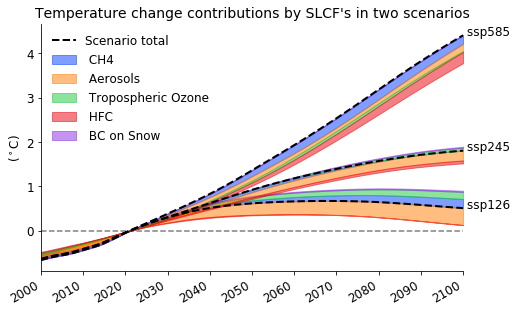

In [29]:
SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


s_y = '2021'
s_y2 = '2000'
e_y = '2100'
e_y2 = '2100'

scenarios_ss = ['ssp126','ssp245', 'ssp585']
ref_var_erf = 'Effective Radiative Forcing|Anthropogenic'
ref_var_dt = new_varname(ref_var_erf, name_deltaT)
# make subset and ref to year s_y:
_ds = ds_DT.sel(scenario=scenarios_ss, time=slice(s_y2, e_y2)) - ds_DT.sel(scenario=scenarios_ss,
                                                                           time=slice(s_y, s_y)).squeeze()
cdic1 = get_cmap_dic(variables_erf_comp, palette='bright')
cdic2 = get_cmap_dic(variables_dt_comp, palette='bright')
cdic = dict(**cdic1, **cdic2)
first=True
for ref_var, varl in zip([ref_var_dt],
                             [variables_dt_comp, variables_erf_comp]):
    fig, ax = plt.subplots(1, figsize=[7, 4.5])
    ax.plot(_ds['time'], np.zeros(len(_ds['time'])), c='k', alpha=0.5, linestyle='dashed')
    # print(ref_var)
    for scn in scenarios_ss[:]:
        # print(scn)
        # subtract year 
        _base = _ds[ref_var]  # _ds.sel(scenario=scn)
        _base = _base.sel(scenario=scn,
                          time=slice(s_y2, e_y2))  # -_base.sel(scenario=scn, time=slice(s_y, s_y)).squeeze()
        # .mean(climatemodel)
        base_keep = _base.mean(climatemodel)
        basep = _base.mean(climatemodel)
        basem = _base.mean(climatemodel)
        # print(base)
        if first:
            base_keep.plot(c='k', linewidth=2, linestyle='dashed', ax=ax, label='Scenario total ')
            first=False
        else:
            base_keep.plot(c='k', linewidth=2, linestyle='dashed', ax=ax, label='_nolegend_')
            
        scen_ds = _ds[varl] - base_keep
        test_df = scen_ds.sel(scenario=scn).mean(climatemodel).to_dataframe()
        for var in varl:
            if scn == scenarios_ss[0]:
                #label = '$\Delta$T ' + var.split('|')[-1]
                label = ' ' + var.split('|')[-1]
            else:
                label = '_nolegend_'

            _pl_da = (_ds[var].sel(scenario=scn, time=slice(s_y2, e_y2)).mean(climatemodel))  # -base_keep)
            if _pl_da.mean() <= 0:
                # print(var)

                ax.fill_between(base_keep['time'].values, basep, -_pl_da + basep, alpha=0.5,
                                color=cdic[var], label=label)
                basep = basep - _pl_da
            else:
                ax.fill_between(base_keep['time'].values, basem, basem - _pl_da, alpha=0.5,
                                color=cdic[var], label=label)
                basem = basem - _pl_da
        if 'Delta T' in ref_var:
            x_val = '2100'
            y_val = base_keep.sel(time=x_val)
            if scn == 'ssp585':
                kwargs = {'xy': (x_val, y_val )}#, 'rotation': 28.6}
            else:
                kwargs = {'xy': (x_val, y_val )}
            #ax.annotate('$\Delta$T, %s' % scn, **kwargs)
            ax.annotate(' %s' % scn, **kwargs)

    ax.legend(frameon=False, loc=2)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ax.set_xlim([s_y2, e_y2])
    #ax.set_ylabel('$\Delta$T (C$^\circ$)')
    ax.set_ylabel('($^\circ$C)')
    ax.set_xlabel('')
    plt.title('Temperature change contributions by SLCF\'s in two scenarios', fontsize=14)
    plt.tight_layout()
    plt.savefig(FIGURE_DIR +'/ssp858_126_relative_contrib.png', dpi=300)
    plt.show()

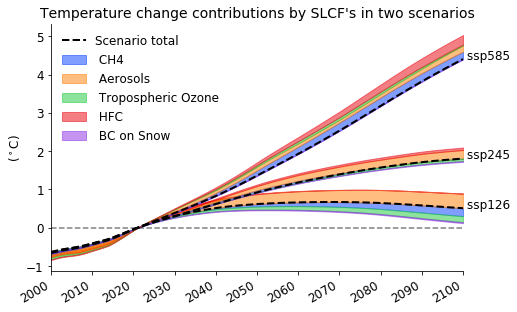

In [40]:
SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


s_y = '2021'
s_y2 = '2000'
e_y = '2100'
e_y2 = '2100'

scenarios_ss = ['ssp126','ssp245', 'ssp585']
ref_var_erf = 'Effective Radiative Forcing|Anthropogenic'
ref_var_dt = new_varname(ref_var_erf, name_deltaT)
# make subset and ref to year s_y:
_ds = ds_DT.sel(scenario=scenarios_ss, time=slice(s_y2, e_y2)) - ds_DT.sel(scenario=scenarios_ss,
                                                                           time=slice(s_y, s_y)).squeeze()
cdic1 = get_cmap_dic(variables_erf_comp, palette='bright')
cdic2 = get_cmap_dic(variables_dt_comp, palette='bright')
cdic = dict(**cdic1, **cdic2)
first=True
for ref_var, varl in zip([ref_var_dt],
                             [variables_dt_comp, variables_erf_comp]):
    fig, ax = plt.subplots(1, figsize=[7, 4.5])
    ax.plot(_ds['time'], np.zeros(len(_ds['time'])), c='k', alpha=0.5, linestyle='dashed')
    # print(ref_var)
    for scn in scenarios_ss[:]:
        # print(scn)
        # subtract year 
        _base = _ds[ref_var]  # _ds.sel(scenario=scn)
        _base = _base.sel(scenario=scn,
                          time=slice(s_y2, e_y2))  # -_base.sel(scenario=scn, time=slice(s_y, s_y)).squeeze()
        
        base_keep = _base.mean(climatemodel)
        basep = _base.mean(climatemodel)
        basem = _base.mean(climatemodel)
        if first:
            base_keep.plot(c='k', linewidth=2, linestyle='dashed', ax=ax, label='Scenario total ')
            first=False
        else:
            base_keep.plot(c='k', linewidth=2, linestyle='dashed', ax=ax, label='_nolegend_')
            
        #scen_ds = _ds[varl] - base_keep
        #test_df = scen_ds.sel(scenario=scn).mean(climatemodel).to_dataframe()
        for var in varl:
            if scn == scenarios_ss[0]:
                #label = '$\Delta$T ' + var.split('|')[-1]
                label = ' ' + var.split('|')[-1]
            else:
                label = '_nolegend_'

            _pl_da = (_ds[var].sel(scenario=scn, time=slice(s_y2, e_y2)).mean(climatemodel))  # -base_keep)
            if _pl_da.mean() <= 0:
                # print(var)

                ax.fill_between(base_keep['time'].values, basep+_pl_da, basep, alpha=0.5,
                                color=cdic[var], label=label)
                basep = basep + _pl_da
            else:
                ax.fill_between(base_keep['time'].values, basem, basem + _pl_da, alpha=0.5,
                                color=cdic[var], label=label)
                basem = basem + _pl_da
        if 'Delta T' in ref_var:
            x_val = '2100'
            y_val = base_keep.sel(time=x_val)
            if scn == 'ssp585':
                kwargs = {'xy': (x_val, y_val ), 'rotation': 0}#28.6}
            else:
                kwargs = {'xy': (x_val, y_val )}
            #ax.annotate('$\Delta$T, %s' % scn, **kwargs)
            ax.annotate(' %s' % scn, **kwargs)

    ax.legend(frameon=False, loc=2)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ax.set_xlim([s_y2, e_y2])
    #ax.set_ylabel('$\Delta$T (C$^\circ$)')
    ax.set_ylabel('($^\circ$C)')
    ax.set_xlabel('')
    plt.title('Temperature change contributions by SLCF\'s in two scenarios', fontsize=14)
    plt.tight_layout()
    plt.savefig(FIGURE_DIR +'/ssp858_126_relative_contrib_rev.png', dpi=300)
    plt.show()

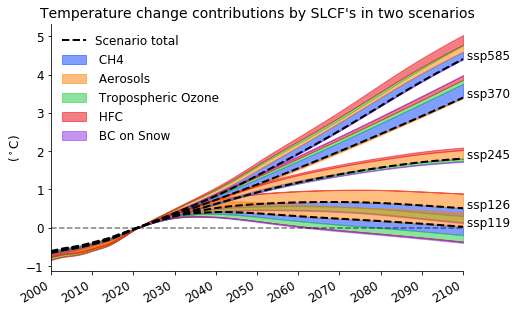

In [34]:
SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


s_y = '2021'
s_y2 = '2000'
e_y = '2100'
e_y2 = '2100'

scenarios_ss = list(set( scenarios_fl) - {'historical','ssp370-lowNTCF-aerchemmip'})# 'ssp'#['ssp126','ssp245', 'ssp585']
ref_var_erf = 'Effective Radiative Forcing|Anthropogenic'
ref_var_dt = new_varname(ref_var_erf, name_deltaT)
# make subset and ref to year s_y:
_ds = ds_DT.sel(scenario=scenarios_ss, time=slice(s_y2, e_y2)) - ds_DT.sel(scenario=scenarios_ss,
                                                                           time=slice(s_y, s_y)).squeeze()
cdic1 = get_cmap_dic(variables_erf_comp, palette='bright')
cdic2 = get_cmap_dic(variables_dt_comp, palette='bright')
cdic = dict(**cdic1, **cdic2)
first=True
for ref_var, varl in zip([ref_var_dt],
                             [variables_dt_comp, variables_erf_comp]):
    fig, ax = plt.subplots(1, figsize=[7, 4.5])
    ax.plot(_ds['time'], np.zeros(len(_ds['time'])), c='k', alpha=0.5, linestyle='dashed')
    # print(ref_var)
    for scn in scenarios_ss[:]:
        # print(scn)
        # subtract year 
        _base = _ds[ref_var]  # _ds.sel(scenario=scn)
        _base = _base.sel(scenario=scn,
                          time=slice(s_y2, e_y2))  # -_base.sel(scenario=scn, time=slice(s_y, s_y)).squeeze()
        
        base_keep = _base.mean(climatemodel)
        basep = _base.mean(climatemodel)
        basem = _base.mean(climatemodel)
        if first:
            base_keep.plot(c='k', linewidth=2, linestyle='dashed', ax=ax, label='Scenario total ')
            first=False
        else:
            base_keep.plot(c='k', linewidth=2, linestyle='dashed', ax=ax, label='_nolegend_')
            
        #scen_ds = _ds[varl] - base_keep
        #test_df = scen_ds.sel(scenario=scn).mean(climatemodel).to_dataframe()
        for var in varl:
            if scn == scenarios_ss[0]:
                #label = '$\Delta$T ' + var.split('|')[-1]
                label = ' ' + var.split('|')[-1]
            else:
                label = '_nolegend_'

            _pl_da = (_ds[var].sel(scenario=scn, time=slice(s_y2, e_y2)).mean(climatemodel))  # -base_keep)
            if _pl_da.mean() <= 0:
                # print(var)

                ax.fill_between(base_keep['time'].values, basep+_pl_da, basep, alpha=0.5,
                                color=cdic[var], label=label)
                basep = basep + _pl_da
            else:
                ax.fill_between(base_keep['time'].values, basem, basem + _pl_da, alpha=0.5,
                                color=cdic[var], label=label)
                basem = basem + _pl_da
        if 'Delta T' in ref_var:
            x_val = '2100'
            y_val = base_keep.sel(time=x_val)
            if scn == 'ssp585':
                kwargs = {'xy': (x_val, y_val ), 'rotation': 0}#28.6}
            else:
                kwargs = {'xy': (x_val, y_val )}
            #ax.annotate('$\Delta$T, %s' % scn, **kwargs)
            ax.annotate(' %s' % scn, **kwargs)

    ax.legend(frameon=False, loc=2)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ax.set_xlim([s_y2, e_y2])
    #ax.set_ylabel('$\Delta$T (C$^\circ$)')
    ax.set_ylabel('($^\circ$C)')
    ax.set_xlabel('')
    plt.title('Temperature change contributions by SLCF\'s in two scenarios', fontsize=14)
    plt.tight_layout()
    plt.savefig(FIGURE_DIR +'/ssp858_126_relative_contrib_rev.png', dpi=300)
    plt.show()

TODO:  Alternative: Do one graph for each component AND the total? 

## What question does the graph answer?
- What are the relative contributions of SLCFs?
    - The figure above shows the contributions of 5 SLCFs and the total anthropogenic forcing in two scenarios (black line) relative to year 2021. The area signifies the warming (below the total) or cooling (above the stipled line) introduced by changes in the SLCFer in the specific scenario. Note that in the in the businiss as usual scenario, all the SLCFers except BC on snow add to the warming, while in the 126 scenario, the emission control acts to reduce methane, ozone and BC, and these are thus contributing to cooling. Both scenarios include emission controls which act to reduce aerosols relative 2021 and thus the aerosols give warming. However, the warming from aerosols is much stronger in ssp126 because of stricter emission control in this scenario. 

- 
